# Imports

In [1]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Review Labeling

##Exploring data

In [3]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return ' {v:d} ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct

In [4]:
cat_labs = ['Food','Interior','Price','Whole','Service']

In [5]:
tr_cats =  pd.read_csv('/content/cats_train.csv', header=0, names= ['rev_id', 'text','Food','Interior','Price','Whole','Service'])

In [6]:
tr_cats.head()

,rev_id,text,Food,Interior,Price,Whole,Service
0,3976,"День 8-го марта прошёл, можно и итоги подвести...",positive,positive,absence,positive,positive
1,30808,Отмечали в этом ресторане день рождение на пер...,positive,positive,positive,positive,positive
2,14031,Хочу поделиться своим впечатлением от посещени...,absence,positive,absence,positive,positive
3,2495,Добрый день! Были вчера с друзьями в этом кафе...,positive,positive,absence,positive,positive
4,38835,Отметили с мужем годовщину свадьбы 6 ноября в ...,both,absence,negative,negative,positive


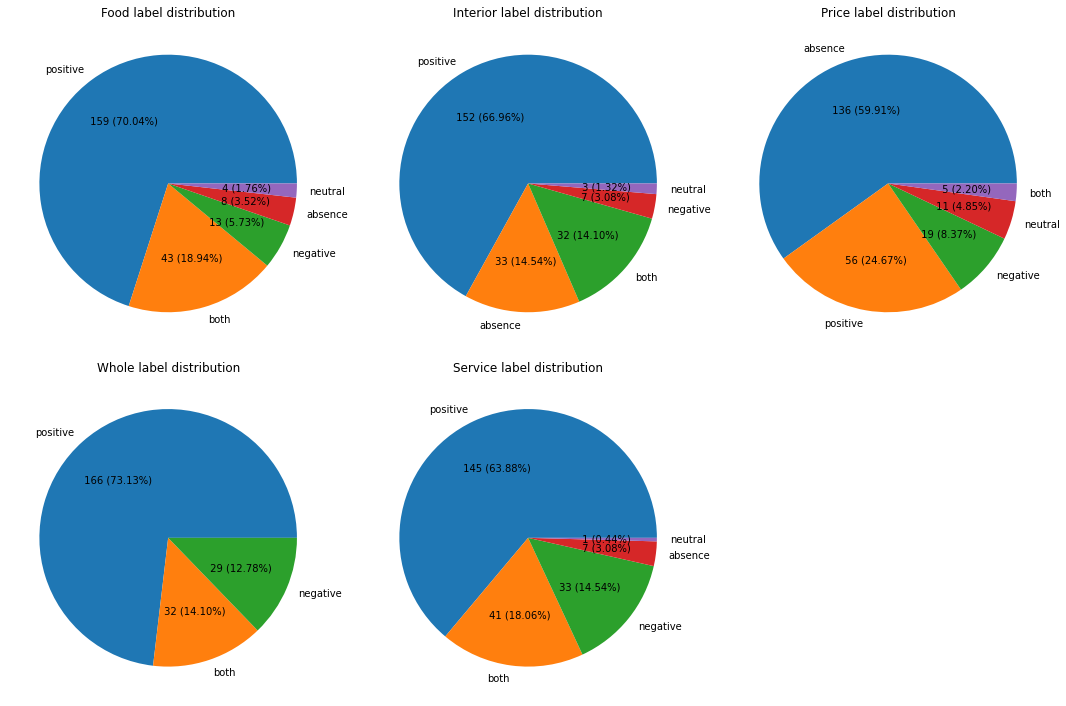

In [7]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(tr_cats.columns[-5:]):
  ax = fig.add_subplot(2, 3, i+1)
  counts = tr_cats[col].value_counts().to_dict()
  ax.pie(counts.values(), labels=counts.keys(), autopct=make_autopct(counts.values()))
  ax.set_title(col+' label distribution')
plt.tight_layout()
plt.show()

In [8]:
cats_dev =  pd.read_csv('/content/dev_cats.txt', sep='\t', header=0, names= ['rev_id', 'cat', 'sent'])

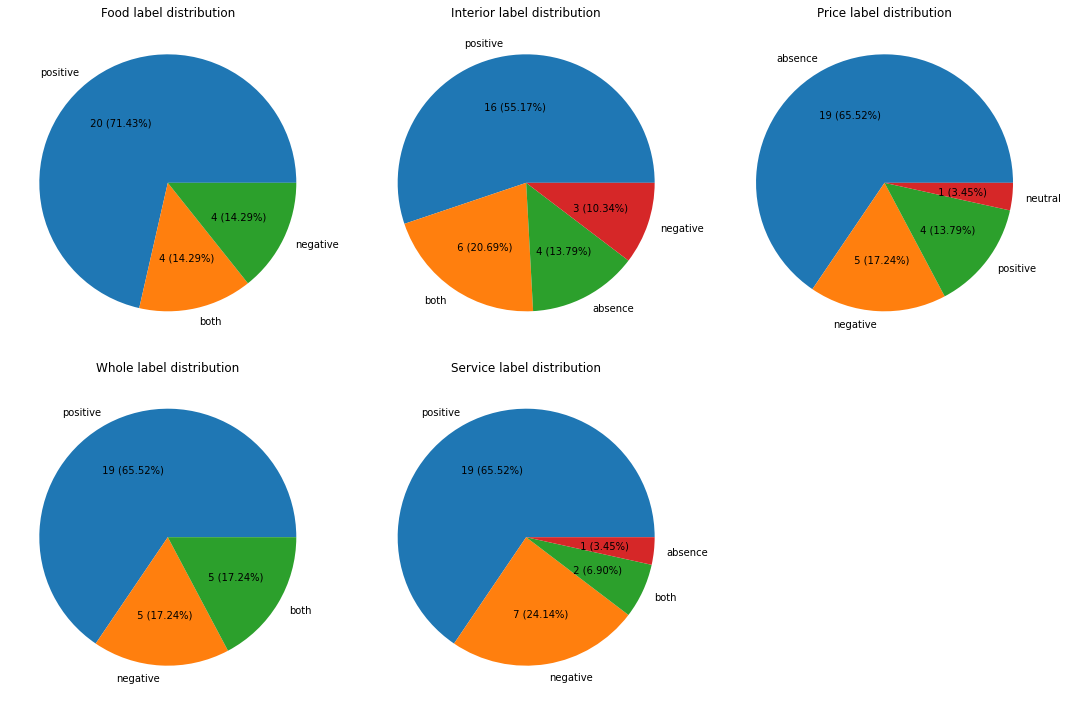

In [9]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_labs):
  ax = fig.add_subplot(2, 3, i+1)
  cat_df = cats_dev[cats_dev['cat'] == col]
  counts = cat_df['sent'].value_counts().to_dict()
  ax.pie(counts.values(), labels=counts.keys(), autopct=make_autopct(counts.values()))
  ax.set_title(col+' label distribution')
plt.tight_layout()
plt.show()

Заметен сильный дизбаланс классов, настолько сильный, что некоторые сочетания категории и сентимента не попали в тестовую выборку

##Exploring results

In [10]:
cat_preds = pd.read_csv('/content/dev_pred_cats.txt', sep='\t', header=0, names= ['rev_id', 'cat', 'sent'])
cat_true = pd.read_csv('/content/dev_cats.txt', sep='\t', header=0, names= ['rev_id', 'cat', 'sent'])

In [11]:
preds = {}
trues = {}
for cat_lab in cat_labs:
  preds[cat_lab] = cat_preds[cat_preds['cat'] == cat_lab]
  trues[cat_lab] = cat_true[cat_preds['cat'] == cat_lab]

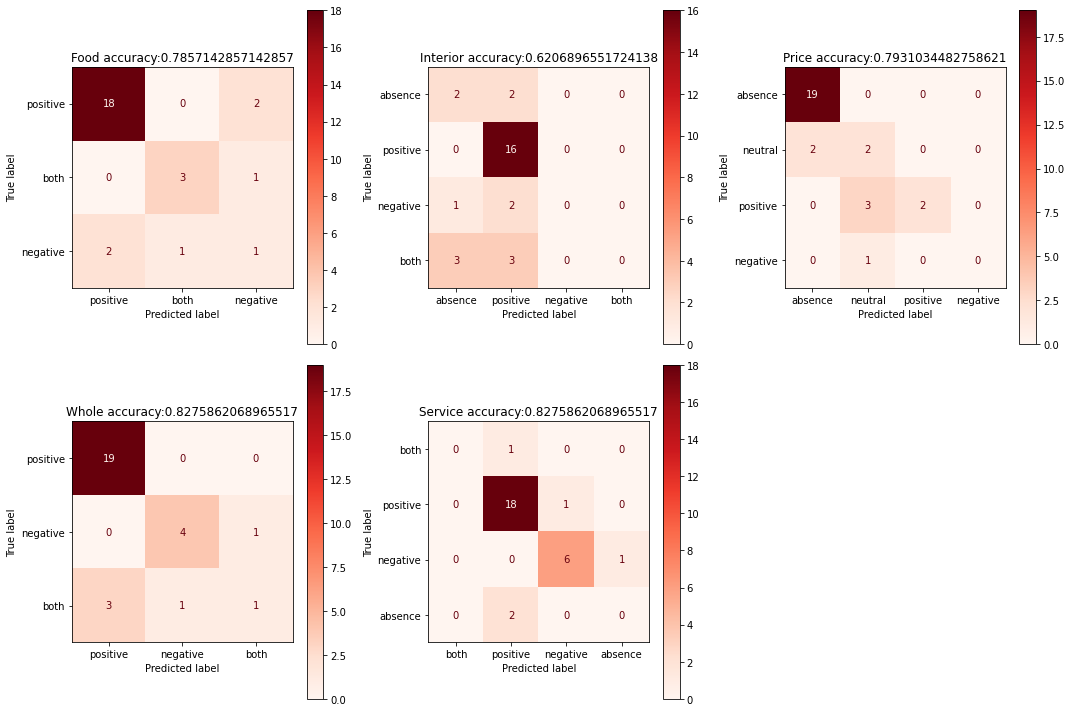

In [29]:
sent_to_int = {"absence": 0, "positive": 1, "negative": 2, "both": 3, "neutral": 4}
fig = plt.figure(figsize=(15, 10))
for i, cat in enumerate(preds.keys()):
  ax = fig.add_subplot(2, 3, i+1)
  cur_sent_to_int = {ct: sent_to_int[ct] for ct in trues[cat]['sent'].unique()}
  true_labs = trues[cat]['sent'].apply(lambda x: cur_sent_to_int[x]).to_numpy()
  pred_labs = preds[cat]['sent'].apply(lambda x: cur_sent_to_int[x]).to_numpy()
  acc = accuracy_score(true_labs, pred_labs)
  cm =ConfusionMatrixDisplay.from_predictions(true_labs, pred_labs, ax=ax, display_labels=cur_sent_to_int.keys(), cmap='Reds')
  ax.set_title(cat+' accuracy:' + str(acc))
plt.tight_layout()
plt.savefig(fname = 'rev_cat_cm.pdf')
plt.show()

Сразу видно, что модель пошла по пути наименьшего сопротивления: хорошо угадывается самый частый сентимент в категории, в то время как редкие сентименты могут вовсе не предсказываться. В нашем случае чиниться такой bias может только сбором большего количества обучающих данных и созданием сбалансированных выборок (например, намеренным бутстрапингом редкими категориями)

#Aspect labeling

##Exploring data

In [24]:
aspects= pd.read_csv('/content/train_aspects.txt', sep='\t', header=0, names=['rev_id', 'cat', 'text', 'start', 'end', 'sent'])

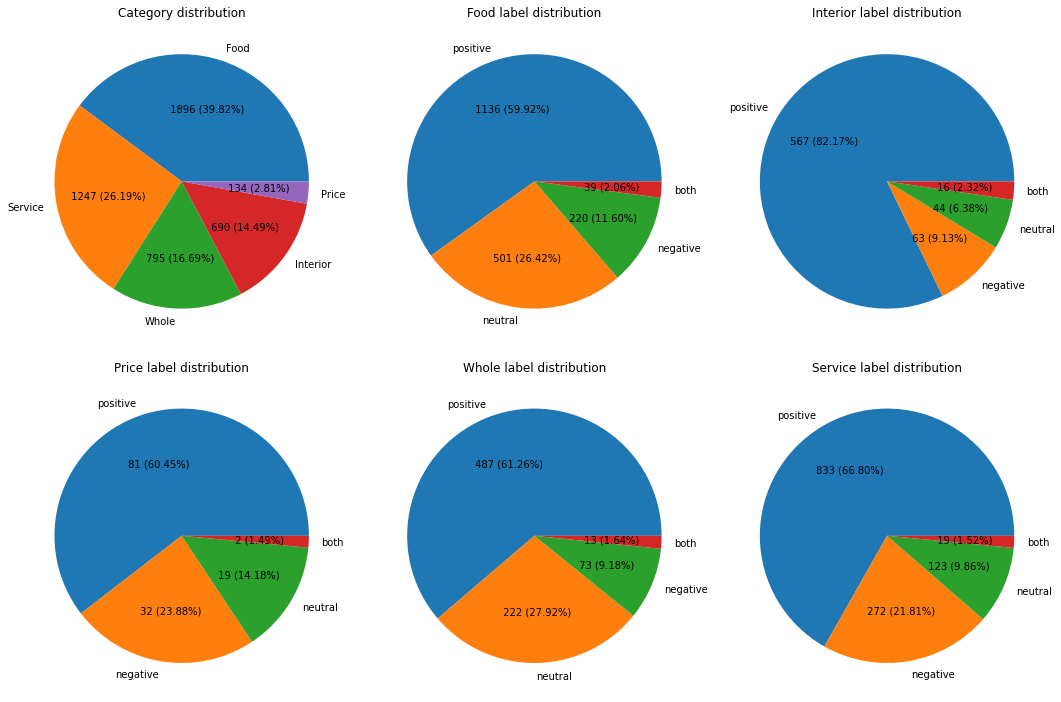

In [28]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
cat_counts = aspects['cat'].value_counts().to_dict()
ax.pie(cat_counts.values(), labels=cat_counts.keys(), autopct=make_autopct(cat_counts.values()))
ax.set_title('Category distribution')
for i, col in enumerate(cat_labs):
  ax = fig.add_subplot(2, 3, i+2)
  cur_cat = aspects[aspects['cat'] == col]
  counts =cur_cat['sent'].value_counts().to_dict()
  ax.pie(counts.values(), labels=counts.keys(), autopct=make_autopct(counts.values()))
  ax.set_title(col+' label distribution')
plt.tight_layout()
plt.show()

In [44]:
dev_aspects= pd.read_csv('/content/dev_aspects.txt', sep='\t', header=0, names=['rev_id', 'cat', 'text', 'start', 'end', 'sent'])

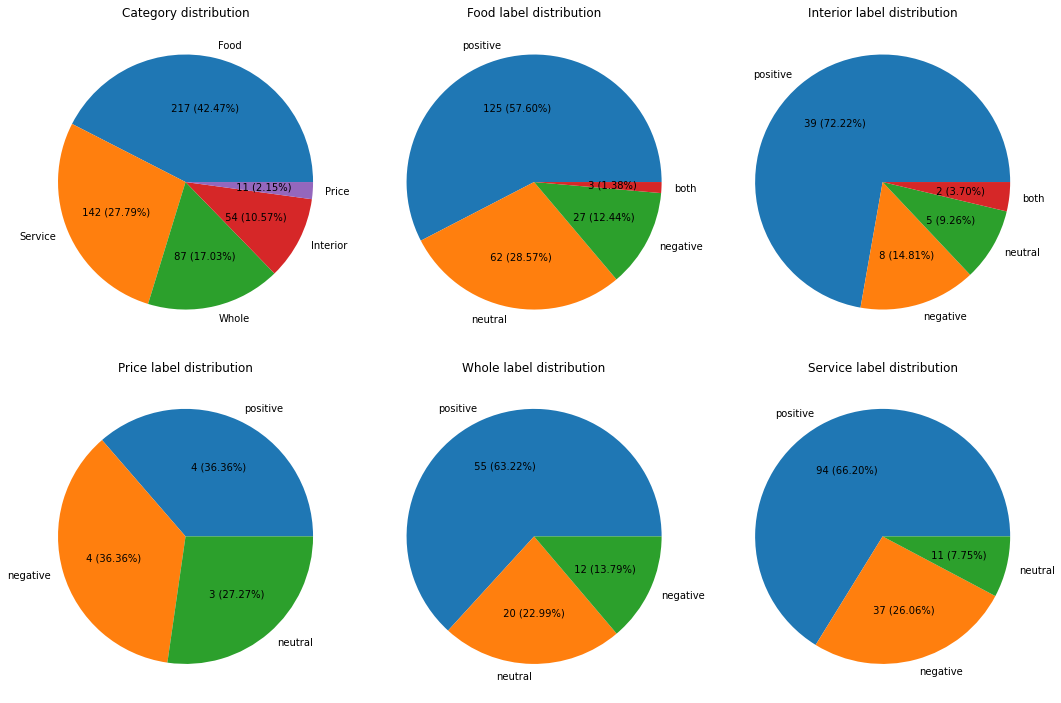

In [45]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
cat_counts = dev_aspects['cat'].value_counts().to_dict()
ax.pie(cat_counts.values(), labels=cat_counts.keys(), autopct=make_autopct(cat_counts.values()))
ax.set_title('Category distribution')
for i, col in enumerate(cat_labs):
  ax = fig.add_subplot(2, 3, i+2)
  cur_cat = dev_aspects[dev_aspects['cat'] == col]
  counts =cur_cat['sent'].value_counts().to_dict()
  ax.pie(counts.values(), labels=counts.keys(), autopct=make_autopct(counts.values()))
  ax.set_title(col+' label distribution')
plt.tight_layout()
plt.show()

Заметен сильный дизбаланс классов, настолько сильный, что некоторые сочетания категории и сентимента не попали в тестовую выборку (впрочем, ничего нового)

##Exploring results

In [31]:
from collections import defaultdict
gold_aspect_cats = {}
split_pattern = re.compile('[^А-Яа-яЁё]')
with open('/content/dev_aspects.txt') as fg:
    for line in fg:
        line = line.rstrip('\r\n').split('\t')
        if line[0] not in gold_aspect_cats:
            gold_aspect_cats[line[0]] = {"starts":[], "ends":[], "text":[], "cats":[], "sents":[]}
        gold_aspect_cats[line[0]]["starts"].append(int(line[3]))
        gold_aspect_cats[line[0]]["ends"].append(int(line[4]))
        gold_aspect_cats[line[0]]["text"].append(line[2])
        gold_aspect_cats[line[0]]["cats"].append(line[1])
        gold_aspect_cats[line[0]]["sents"].append(line[5])
full_match, partial_match, full_cat_match, partial_cat_match = 0, 0, 0, 0
total = 0
fully_matched_pairs = []
partially_matched_pairs = []
with open('/content/dev_pred_aspects.txt') as fp:
    for line in fp:    
        total += 1
        line = line.rstrip('\r\n').split('\t')
        start, end = int(line[3]), int(line[4])
        category = line[1]
        doc_gold_aspect_cats = gold_aspect_cats[line[0]]
        if start in doc_gold_aspect_cats["starts"]:
            i = doc_gold_aspect_cats["starts"].index(start)
            if doc_gold_aspect_cats["ends"][i] == end:
                full_match += 1
                if doc_gold_aspect_cats["cats"][i] == category:
                    full_cat_match += 1
                else:
                    partial_cat_match += 1
                fully_matched_pairs.append(
                    (
                        [
                            doc_gold_aspect_cats["text"][i],
                            doc_gold_aspect_cats["starts"][i], 
                            doc_gold_aspect_cats["ends"][i], 
                            doc_gold_aspect_cats["cats"][i],
                            doc_gold_aspect_cats["sents"][i]
                        ],
                        [line[2], int(line[3]), int(line[4]), line[1], line[5]]
                    )
                )
                continue
        for s_pos in doc_gold_aspect_cats["starts"]:
            if start <= s_pos:
                i = doc_gold_aspect_cats["starts"].index(s_pos)
                if doc_gold_aspect_cats["ends"][i] == end:
                    partial_match += 1
                    partially_matched_pairs.append(
                        (
                            [
                                doc_gold_aspect_cats["text"][i],
                                len(re.sub(split_pattern, ' ', doc_gold_aspect_cats["text"][i]).split()),
                                doc_gold_aspect_cats["starts"][i], 
                                doc_gold_aspect_cats["ends"][i], 
                                doc_gold_aspect_cats["cats"][i],
                                doc_gold_aspect_cats["sents"][i]
                            ],
                            [line[2], len(re.sub(split_pattern, ' ', line[2]).split()), int(line[3]), int(line[4]), line[1], line[5]]
                        )
                    )
                    if doc_gold_aspect_cats["cats"][i] == category:
                        partial_cat_match += 1
                    continue
                matched = False
                for e_pos in doc_gold_aspect_cats["ends"][i:]:
                    if s_pos <= end <= e_pos:
                        partial_match += 1
                        partially_matched_pairs.append(
                            (
                                [
                                    doc_gold_aspect_cats["text"][i],
                                    len(re.sub(split_pattern, ' ', doc_gold_aspect_cats["text"][i]).split()),
                                    doc_gold_aspect_cats["starts"][i], 
                                    doc_gold_aspect_cats["ends"][i], 
                                    doc_gold_aspect_cats["cats"][i],
                                    doc_gold_aspect_cats["sents"][i]
                                ],
                                [line[2], len(re.sub(split_pattern, ' ', line[2]).split()), int(line[3]), int(line[4]), line[1], line[5]]
                            )
                        )
                        if doc_gold_aspect_cats["cats"][i] == category:
                            partial_cat_match += 1
                        matched = True
                        break
                if matched:
                    break
            if start > s_pos:
                i = doc_gold_aspect_cats["starts"].index(s_pos)
                if start < doc_gold_aspect_cats["ends"][i] <= end:
                    partial_match += 1
                    partially_matched_pairs.append(
                        (
                            [
                                doc_gold_aspect_cats["text"][i],
                                len(re.sub(split_pattern, ' ', doc_gold_aspect_cats["text"][i]).split()),
                                doc_gold_aspect_cats["starts"][i], 
                                doc_gold_aspect_cats["ends"][i], 
                                doc_gold_aspect_cats["cats"][i],
                                doc_gold_aspect_cats["sents"][i]
                            ],
                            [line[2], len(re.sub(split_pattern, ' ', line[2]).split()), int(line[3]), int(line[4]), line[1], line[5]]
                        )
                    )
                    if doc_gold_aspect_cats["cats"][i] == category:
                        partial_cat_match += 1
                    break

In [33]:
full_df = pd.DataFrame([x[0] + x[1][-2:] for x in fully_matched_pairs], columns = ['text', 'start', 'end', 'true_cat', 'true_sent', 'pred_cat', 'pred_sent'])

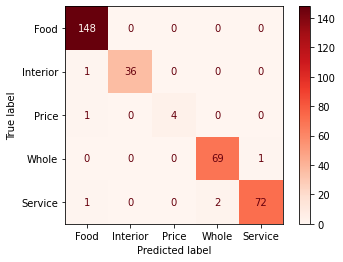

In [34]:
cat_to_int = {'Food': 0,'Interior': 1,'Price': 2,'Whole': 3,'Service': 4}
true_labs = full_df['true_cat'].apply(lambda x: cat_to_int[x]).to_numpy()
pred_labs =  full_df['pred_cat'].apply(lambda x: cat_to_int[x]).to_numpy()
acc = accuracy_score(true_labs, pred_labs)
cm =ConfusionMatrixDisplay.from_predictions(true_labs, pred_labs, display_labels=cat_to_int.keys(), cmap='Reds')
plt.savefig(fname='asp_cats.pdf')

In [35]:
full_df[full_df['true_cat'] !=full_df['pred_cat']]

,text,start,end,true_cat,true_sent,pred_cat,pred_sent
190,ресторанчик,118,129,Service,neutral,Whole,neutral
204,атомосфере,913,923,Interior,positive,Food,positive
267,Обслуживание,712,724,Whole,positive,Service,positive
274,чек,143,146,Price,positive,Food,positive
285,повар,1040,1045,Service,negative,Food,negative
292,бар,404,407,Service,positive,Whole,positive


Тут предсказуемо: либо путаем с самой частой (Food), либо путаем реально похожие Service и Whole

In [36]:
pd.options.display.max_colwidth = 200

{'both': 3, 'neutral': 4, 'positive': 1, 'negative': 2}

Food confusion words:
true_sent  pred_sent
both       negative                                                                                                                                                                          пиццу
           neutral                                                                                                                                                                            суши
           positive                                                                                                                                                                           суши
negative   neutral                                                                                                                              десерт | суши | пасту | суши | соусом | мясо | еду
           positive                                                                                                     

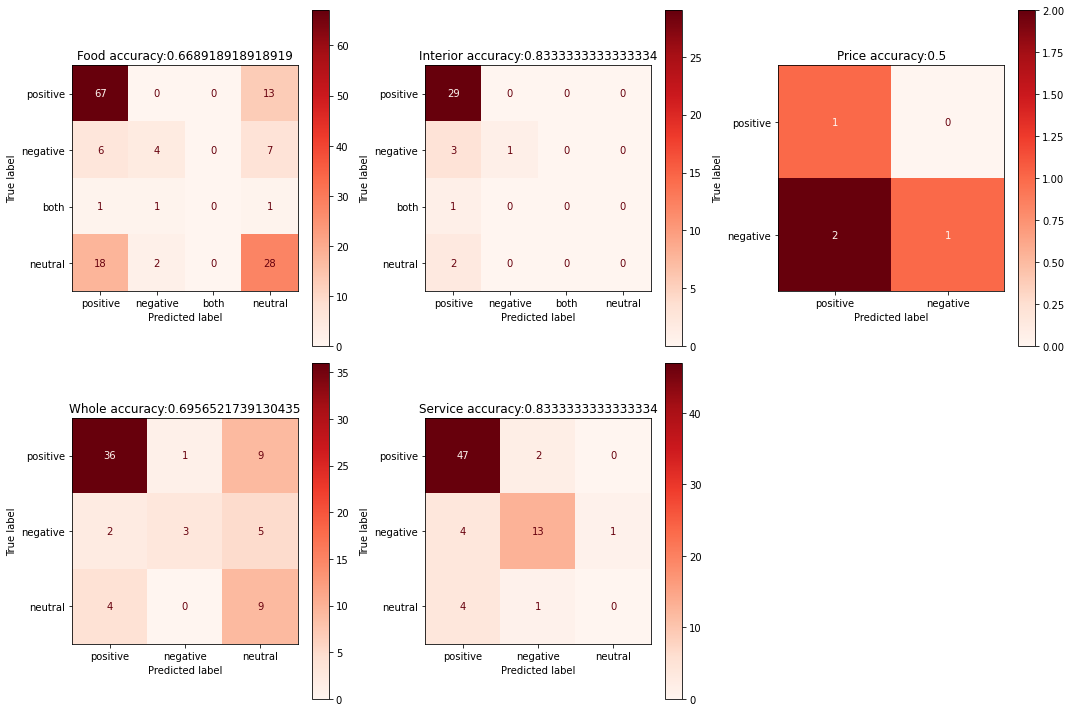

In [53]:
full_cat_match_df = full_df[full_df['true_cat'] == full_df['pred_cat']]
sent_to_int = {"absence": 0, "positive": 1, "negative": 2, "both": 3, "neutral": 4}
fig = plt.figure(figsize=(15, 10))
for i, cat in enumerate(cat_labs):
  ax = fig.add_subplot(2, 3, i+1)
  cur_cat_df = full_cat_match_df[full_cat_match_df['true_cat'] == cat]
  cur_sent_to_int = {ct: sent_to_int[ct] for ct in  set(cur_cat_df['true_sent'].unique()) |  set(cur_cat_df['pred_sent'].unique())}
  print(cur_sent_to_int)
  true_labs = cur_cat_df['true_sent'].apply(lambda x: cur_sent_to_int[x]).to_numpy()
  pred_labs = cur_cat_df['pred_sent'].apply(lambda x: cur_sent_to_int[x]).to_numpy()
  print('\n'+ cat + ' confusion words:')
  print(cur_cat_df[cur_cat_df['true_sent'] != cur_cat_df['pred_sent']].groupby(by=['true_sent', 'pred_sent'])['text'].apply(lambda x: ' | '.join(x)))
  acc = accuracy_score(true_labs, pred_labs)
  cm =ConfusionMatrixDisplay.from_predictions(true_labs, pred_labs, ax=ax, display_labels=sorted(list(cur_sent_to_int.keys()), key=lambda x: cur_sent_to_int[x]), cmap='Reds')
  ax.set_title(cat+' accuracy:' + str(acc))
plt.tight_layout()
plt.savefig(fname='full_sent_cms.pdf')
plt.show()


Распределение ответов, как водится, сильно зависит от изначального распределения лейблов внутри категории: если процент одного сентимента в категории высок (в Interior в трейне более 80%), то модель ленится чуть ли не до уровня majority label, но при наличии хотя бы ещё одного частого лейбла обе категории предсказываются + positive и neutral часто путаются. Также стоит отметить, что часто сами спаны никак собой не маркируют сентимент, кажется, что не хватает какого-то контекста (например, в Whole слово *ресторан* почти  каждом сентименте)

In [38]:
part_df = pd.DataFrame([x[0][:2] + x[0][-2:] + x[1][:2] + x[1][-2:] for x in partially_matched_pairs], columns = ['true_text', 'true_len', 'true_cat', 'true_sent','pred_text', 'pred_len', 'pred_cat', 'pred_sent'])

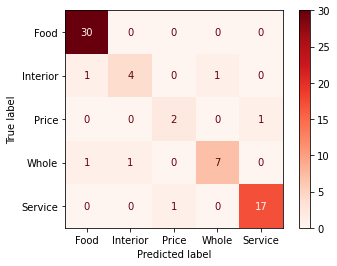

In [39]:
cat_to_int = {'Food': 0,'Interior': 1,'Price': 2,'Whole': 3,'Service': 4}
true_labs = part_df['true_cat'].apply(lambda x: cat_to_int[x]).to_numpy()
pred_labs =  part_df['pred_cat'].apply(lambda x: cat_to_int[x]).to_numpy()
acc = accuracy_score(true_labs, pred_labs)
cm =ConfusionMatrixDisplay.from_predictions(true_labs, pred_labs, display_labels=cat_to_int.keys(), cmap='Reds')
plt.savefig(fname='part_asp_cats.pdf')

In [87]:
part_df[part_df['true_cat'] !=part_df['pred_cat']]

,true_text,true_len,true_cat,true_sent,pred_text,pred_len,pred_cat,pred_sent
4,Обстановка в ресторане,3,Interior,positive,ресторане,1,Whole,positive
36,ресторан Кухню,2,Whole,neutral,Кухню,1,Food,positive
40,счет,1,Price,neutral,счет несли,2,Service,negative
52,площадь ресторана,2,Whole,negative,площадь,1,Interior,positive
56,горячие полотенца,2,Interior,negative,горячие,1,Food,negative
64,счет нам принесли,3,Service,positive,счет,1,Price,negative


Явно виновата сегментация, особенно забавна зеркальность строчек 40 и 64

Overall mean lens: true: 1.8833333333333333, pred: 1.85
Food mean lens: true: 2.066666666666667, pred: 2.066666666666667
Interior mean lens: true: 2.25, pred: 1.25
Price mean lens: true: 2.5, pred: 1.5
Whole mean lens: true: 1.7142857142857142, pred: 1.2857142857142858
Service mean lens: true: 1.4705882352941178, pred: 1.8823529411764706


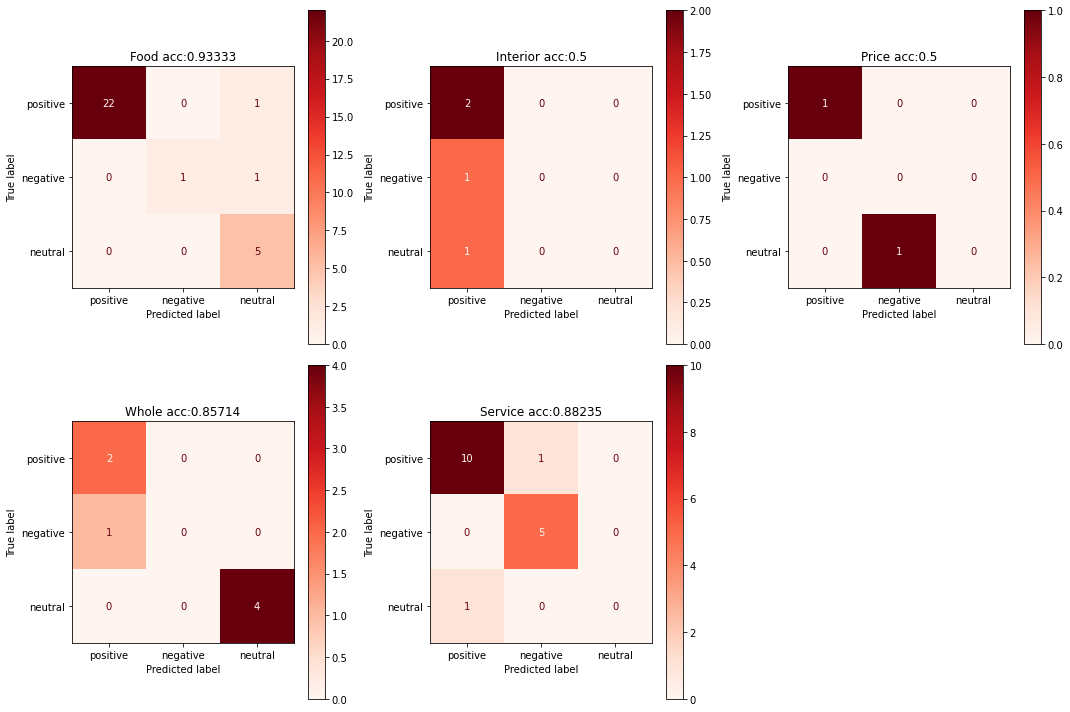

In [51]:
part_cat_match_df = part_df[part_df['true_cat'] == part_df['pred_cat']]
sent_to_int = {"absence": 0, "positive": 1, "negative": 2, "both": 3, "neutral": 4}
print(f'''Overall mean lens: true: {str(part_cat_match_df['true_len'].mean())}, pred: {str(part_cat_match_df['pred_len'].mean())}''')
fig = plt.figure(figsize=(15, 10))
for i, cat in enumerate(cat_labs):
  ax = fig.add_subplot(2, 3, i+1)
  cur_cat_df = part_cat_match_df[part_cat_match_df['true_cat'] == cat]
  cur_sent_to_int = {ct: sent_to_int[ct] for ct in set(cur_cat_df['true_sent'].unique()) |  set(cur_cat_df['pred_sent'].unique())}
  true_labs = cur_cat_df['true_sent'].apply(lambda x: cur_sent_to_int[x]).to_numpy()
  pred_labs = cur_cat_df['pred_sent'].apply(lambda x: cur_sent_to_int[x]).to_numpy()
  print(f'''{cat} mean lens: true: {str(cur_cat_df['true_len'].mean())}, pred: {str(cur_cat_df['pred_len'].mean())}''')
  acc = accuracy_score(true_labs, pred_labs)
  cm =ConfusionMatrixDisplay.from_predictions(true_labs, pred_labs, ax=ax, display_labels=sorted(list(cur_sent_to_int.keys()), key=lambda x: cur_sent_to_int[x]), cmap='Reds')
  ax.set_title(cat+' acc:' + str(round(acc, 5)))
plt.tight_layout()
plt.savefig(fname='part_sent_cms.pdf')
plt.show()

Стоит отметить, что во среднем предсказанные спаны немного короче настоящих, хотя разница весьма мала, и от разнится от категории к категории